<a href="https://colab.research.google.com/github/Ela-Na/ML-Fresh-water-management/blob/main/RNN_Athabaska_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating a Neural Network to Calculate Error
##### Working with the results of the LSTM/GRU inquiry on the working group landing page, this initial exploration will take what was uncovered there and use it in smaller, consistent iterations across the same data. 
##### Both a GRU and LSTM will be tested, though it is expected that the LSTM will perform better. 
###### Code originally from: (https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook)

##### The Sentinel III data, two standard deviations: (https://drive.google.com/file/d/1--rBIMLdoPjeedY9cGQ8-oHA2ERaj-F2/view?usp=sharing) 

In [ ]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
from torch.autograd import Variable

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the target file from Google Drive to local environment
!cp /content/drive/MyDrive/combined_sentinel_cleaned.csv /content/ 

In [ ]:
# Load .csv file into Pandas
from pandas import DataFrame
df = pd.read_csv("combined_sentinel_cleaned.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df.head(5)

,date,lake,latitude,longitude,orbit,water_level
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251
2,20160403,Athabasca,59.250420,-108.051342,303,208.550610
3,20160403,Athabasca,59.253311,-108.053278,303,208.300569
4,20160403,Athabasca,59.256202,-108.055216,303,208.333929


In [ ]:
# Isolate Lake Winnipeg
win = df[df['lake'] == 'Athabasca']
win.head()

,date,lake,latitude,longitude,orbit,water_level
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251
2,20160403,Athabasca,59.250420,-108.051342,303,208.550610
3,20160403,Athabasca,59.253311,-108.053278,303,208.300569
4,20160403,Athabasca,59.256202,-108.055216,303,208.333929


In [ ]:
# Create a resository for errors per timestep 
errors = []
for i in win.date.unique():
  min = win[win['date'] == i].water_level.min()
  max = win[win['date'] == i].water_level.max()
  err = max - min
  errors.append(err)

errors[0:10]

[16.046278699999988,
 28.851447399999984,
 1.8857581000000039,
 4.149435499999981,
 0.4101947999999993,
 7.096868899999976,
 0.6490730000000156,
 31.794120899999996,
 14.972939400000001,
 28.283313899999996]

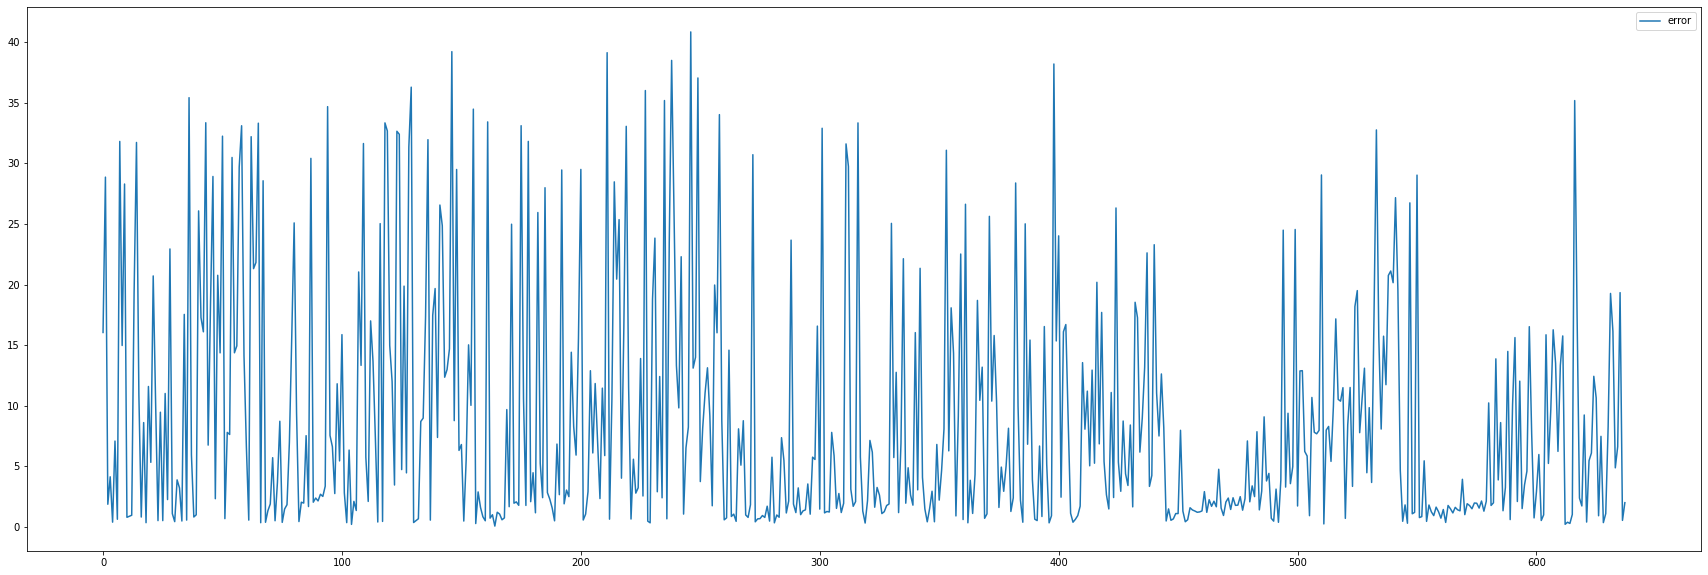

In [ ]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
x = range(len(errors))
y = errors 
plt.plot(x,y, label = "error")
plt.legend()

In [ ]:
# Create a dataframe of the collected errors
err = pd.DataFrame(errors, columns = ['error'])
err.head()

,error
0,16.046279
1,28.851447
2,1.885758
3,4.149435
4,0.410195


In [ ]:
# Transform features by scaling each feature to a given range, to help it become more accurate.
scaler = MinMaxScaler(feature_range=(-1, 1))
err['error'] = scaler.fit_transform(err['error'].values.reshape(-1,1))

In [ ]:
t = 20 # (Which will be the 21st term)
# Take the first 20
err_20 = err.error[0:t]
target = err.error[t:t+1]
print(target)

20   -0.742008
Name: error, dtype: float64


In [ ]:
# Create a function that will split the data into training and testing. 
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
# Split the data into train and test groups.
lookback = 25 # Choose a sequence length. Each timestep is approximately 3 days, so 20 = ~ 60 days/ 2 months.
x_train, y_train, x_test, y_test = split_data(err, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (490, 24, 1)
y_train.shape =  (490, 1)
x_test.shape =  (123, 24, 1)
y_test.shape =  (123, 1)


In [ ]:
# Turn the train and test groups into tensors for use in Pytorch. 
# Herein we will also twin the test group into a GRU and LSTM group.
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
# Now we create the internals of the Deep Learning modles. 
input_dim = 1 # Dimension of input data
hidden_dim = 128 # Number of neurons in a given layer. 
#num_layers = 2 # Number of layers.
output_dim = 1 # The output dimension of the data.
num_epochs = 250 # The number training epochs. With diminishing returns, more is better. 
#                   However, too much more will often lead to overfitting. 
layer_dim = 2     # number of hidden layers



In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out



In [ ]:
'''# batch_size, epoch and iteration for rnn
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

SyntaxError: ignored

In [ ]:
'''# Create a function/class that will be our Pytorch LSTM model. 
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

SyntaxError: ignored

In [ ]:
'''# Instantiating the model, and establishing loss and optimization functions. 
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean') # The loss calculation function.
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # THe optimization calculation function. 

In [ ]:
# Instantiating the model, and establishing loss and optimization functions. 

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss(reduction='mean') # The loss calculation function.
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # THe optimization calculation function.

In [ ]:
'''batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [ ]:
# Execute the model.
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    if t%100 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6161723732948303
Epoch  100 MSE:  0.2413245439529419
Epoch  200 MSE:  0.17805464565753937
Training time: 22.807172298431396


In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

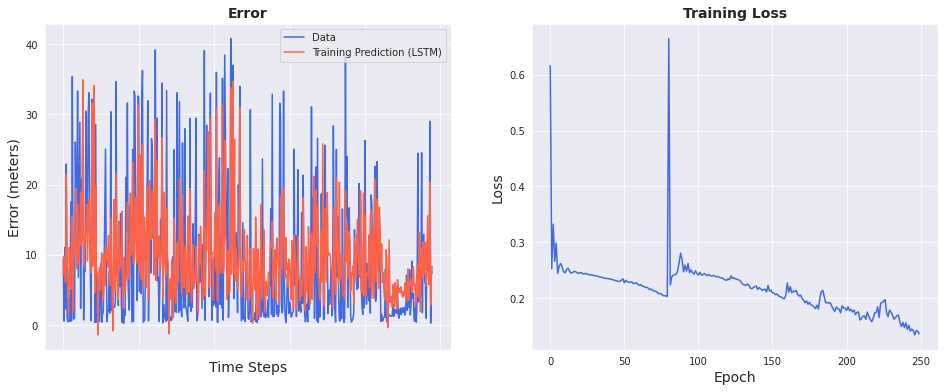

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Error', size = 14, fontweight='bold')
ax.set_xlabel("Time Steps", size = 14)
ax.set_ylabel("Error (meters)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [ ]:


# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 7.52 RMSE
Test Score: 9.88 RMSE


##### Suspicious! A root mean squared error so low often means overfitting. 
##### The graph reveals that the model is certainly very capable at making predictions on the training data. 
#### Now to observe predictions on the test data. 

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(err)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(err)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(err)-1, :] = y_test_pred

original = scaler.inverse_transform(err['error'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Error (meters)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (RNN) for Athabaska',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

##### Initially, the model predicts the error on unseen data quite well. After a certain number of timesteps however, it quickly loses this predictive power. 
##### This suggests that with such a simple, computationally inexpensive LSTM, error can be predicted quite well for five to ten timesteps, which is 15-30 days. 

### Building the Modified Linear Kalman Filter
##### It was recommended that...

In [ ]:
unique = win.date.unique()
water_mean = []
for i in range(len(unique)): 
  mean = win[(win['date'] == unique[i])].water_level.mean()
  water_mean.append(mean)

In [ ]:
# Step 4, building the Model
#Initialization
_o = "old"
_n = "new"
x = "Water Level Estimations"
x_o = water_mean[0]
p = "Estimated Error" 
p_o = np.mean(errors)# --> Error variance

# Initial Prediction
x_n = x_o # (217.3659023809524) 
q = 0.125 # --> Process Uncertainty 
p_n = p_o + q 
x_o = x_n
p_o = p_n 

In [ ]:
kalman_gains = [] # --> To record the Kalman Gains per iteration.
water_est = [] # --> To record the predicted water levels. 
kf_errors = [] # --> To record the estimated errors. 
noise = [] # --> To record the unmeasurable variability, 'q', aka 'noise'

for i in range(len(water_mean)):
  # Measure
  z = water_mean[i]
  err = errors[i] * errors[i]
  # Update
  k = p_n /(p_o + err)
  kalman_gains.append(k)
  x_n = x_o + k * (z-x_o)
  water_est.append(x_n)
  p_n = (1-k)*(p_o)
  if i >= 1:
    if i%80==0:
      rnn = result[2][i] 
      p_n = (1-k)*(rnn)
  kf_errors.append(p_n)
  x_o = x_n
  # Prediction
  x_n = x_o
  p_n = p_o + q
  p_o = p_n
  #Create the Random Forest Regressor pass
  if i >= 1:
    
    if i%80==0:
      rnn = result[2][i] 
      p_n = (1-k)*(p_o) + q
      p_o = p_n
  noise.append(q)

  

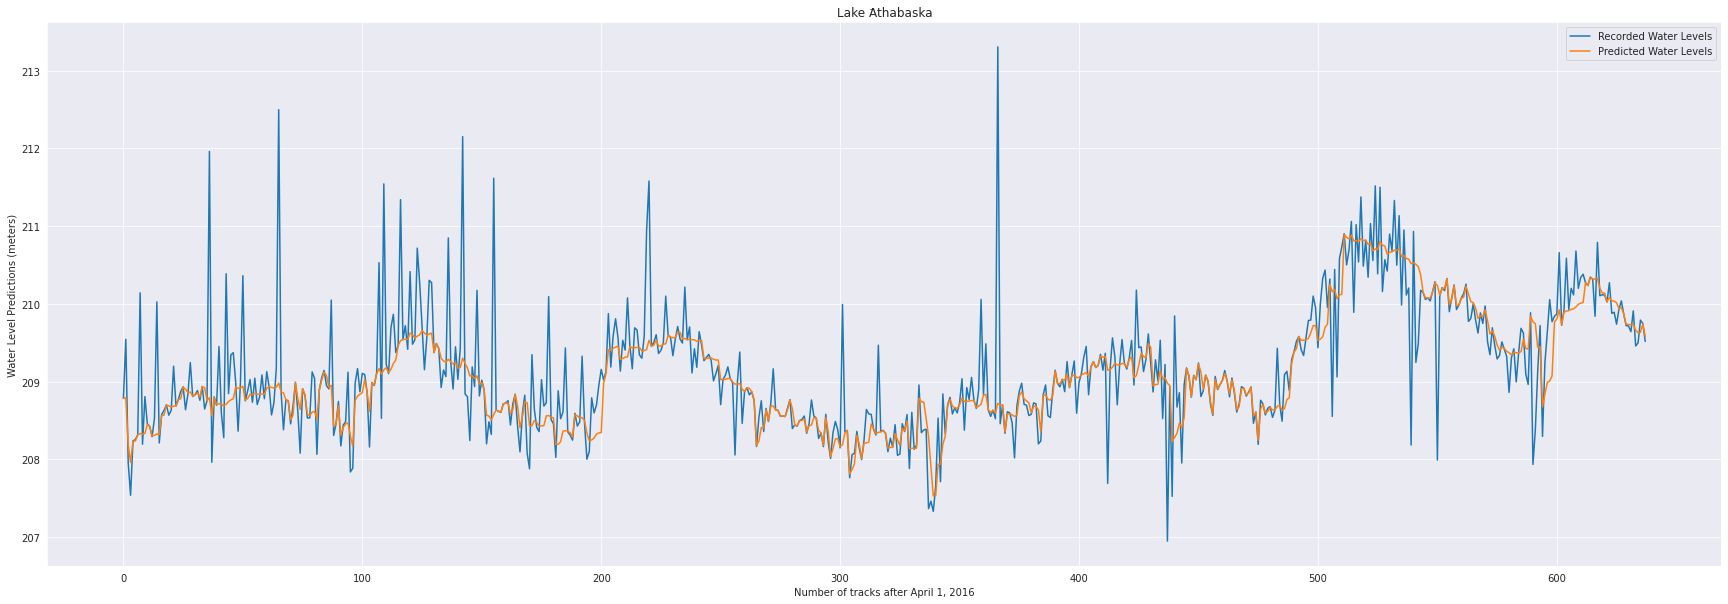

In [ ]:
# Now to plot the estimated water levels against the recorded measurements. 
x = range(len(water_mean))
y2 = water_est
y = water_mean

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake َAthabaska")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Recorded Water Levels')
plt.plot(y2, label = 'Predicted Water Levels')

plt.legend()
plt.show()

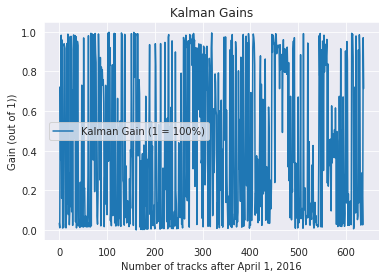

In [ ]:
# And finally to observe if the Kalman Gain was narrowing in on 0:
x = range(len(kalman_gains))
y = kalman_gains
plt.title("Kalman Gains")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Gain (out of 1))")
plt.plot(x,y, label = 'Kalman Gain (1 = 100%)')
plt.legend()
plt.show()

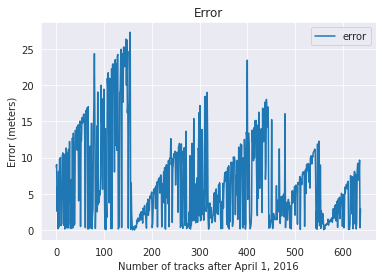

In [ ]:
# And finally to observe what the pattern of the errors is:
x = range(len(errors))
y = kf_errors
plt.title("Error")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y, label='error')
plt.legend()
plt.show()

In [ ]:
total = 0
for i in range(len(water_est)):
  if water_est[i] < water_mean[i]:
    answer = water_est[i]  - (water_mean[i] - ((1-kalman_gains[i])*errors[i]))
  elif water_est[i] >= water_mean[i]:
    answer = water_est[i] - (water_mean[i] + ((1-kalman_gains[i])*errors[i]))
  total += answer

In [ ]:
total

1224.9270128634416

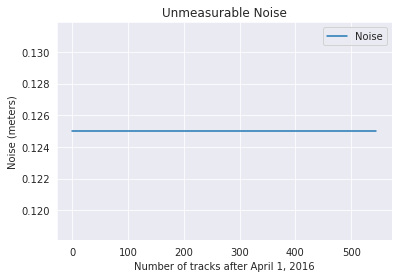

In [ ]:
# And finally to observe if the noise is increasing or decreasing. 
x = range(len(noise))
y = noise
plt.title("Unmeasurable Noise")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Noise (meters)")
plt.plot(x,y, label = 'Noise')
plt.legend()
plt.show()

The Particle Filter
All of this brings us to the particle filter. Consider tracking a robot or a car in an urban environment. For consistency I will use the robot localization problem from the EKF and UKF chapters. In this problem we tracked a robot that has a sensor which measures the range and bearing to known landmarks.

Particle filters are a family of algorithms. I'm presenting a specific form of a particle filter that is intuitive to grasp and relates to the problems we have studied in this book. This will leave a few of the steps seeming a bit 'magical' since I haven't offered a full explanation. That will follow later in the chapter.

Taking insight from the discussion in the previous section we start by creating several thousand particles. Each particle has a position that represents a possible belief of where the robot is in the scene, and perhaps a heading and velocity. Suppose that we have no knowledge of the location of the robot. We would want to scatter the particles uniformly over the entire scene. If you think of all of the particles representing a probability distribution, locations where there are more particles represent a higher belief, and locations with fewer particles represents a lower belief. If there was a large clump of particles near a specific location that would imply that we were more certain that the robot is there.

Each particle needs a weight - ideally the probability that it represents the true position of the robot. This probability is rarely computable, so we only require it be proportional to that probability, which is computable. At initialization we have no reason to favor one particle over another, so we assign a weight of , for  particles. We use  so that the sum of all probabilities equals one.

The combination of particles and weights forms the probability distribution for our problem. Think back to the Discrete Bayes chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. This is very similar except the particles are randomly distributed in a continuous space rather than constrained to discrete locations. In this problem the robot can move on a plane of some arbitrary dimension, with the lower right corner at (0,0).

To track our robot we need to maintain states for x, y, and heading. We will store N particles in a (N, 3) shaped array. The three columns contain x, y, and heading, in that order.

If you are passively tracking something (no control input), then you would need to include velocity in the state and use that estimate to make the prediction. More dimensions requires exponentially more particles to form a good estimate, so we always try to minimize the number of random variables in the state.

This code creates a uniform and Gaussian distribution of particles over a region:

In [ ]:


from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles


In [ ]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [ ]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

##Computing the State Estimate


In most applications you will want to know the estimated state after each update, but the filter consists of nothing but a collection of particles. Assuming that we are tracking one object (i.e. it is unimodal) we can compute the mean of the estimate as the sum of the weighted values of the particles.

 
Here I adopt the notation 
 to indicate the 
 particle. A superscript is used because we often need to use subscripts to denote time steps, yielding the unwieldy 
 for the 
 time step for example.

This function computes both the mean and variance of the particles:

In [ ]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

If we create a uniform distribution of points in a 1x1 square with equal weights we get a mean position very near the center of the square at (0.5, 0.5) and a small variance.

In [ ]:
particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

(array([0.50504393, 0.50652295]), array([0.08151932, 0.08311314]))

##Particle Resampling
The SIS algorithm suffers from the degeneracy problem. It starts with uniformly distributed particles with equal weights. There may only be a handful of particles near the robot. As the algorithm runs any particle that does not match the measurements will acquire an extremely low weight. Only the particles which are near the robot will have an appreciable weight. We could have 5,000 particles with only 3 contributing meaningfully to the state estimate! We say the filter has degenerated.This problem is usually solved by some form of resampling of the particles.

Particles with very small weights do not meaningfully describe the probability distribution of the robot. The resampling algorithm discards particles with very low probability and replaces them with new particles with higher probability. It does that by duplicating particles with relatively high probability. The duplicates are slightly dispersed by the noise added in the predict step. This results in a set of points in which a large majority of the particles accurately represent the probability distribution.

There are many resampling algorithms. For now let's look at one of the simplest, simple random resampling, also called multinomial resampling. It samples from the current particle set  times, making a new set of particles from the sample. The probability of selecting any given particle should be proportional to its weight.

We accomplish this with NumPy's cumsum function. cumsum computes the cumulative sum of an array. That is, element one is the sum of elements zero and one, element two is the sum of elements zero, one and two, etc. Then we generate random numbers in the range of 0.0 to 1.0 and do a binary search to find the weight that most closely matches that number:

In [ ]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

In [ ]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

### Now to test the Gated Recurrent Unit.

In [ ]:
# Create the GRU class for Pytorch
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
# Instantiate, create a loss and optimation function.
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    if t%100 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2759305238723755
Epoch  100 MSE:  0.0064698318019509315
Epoch  200 MSE:  3.4202752431156114e-05
Epoch  300 MSE:  0.0002663789491634816
Epoch  400 MSE:  7.783954814044591e-09
Epoch  500 MSE:  5.114145551488036e-07
Epoch  600 MSE:  2.708395550143905e-05
Epoch  700 MSE:  7.695291626141909e-10
Epoch  800 MSE:  3.3282109842625376e-14
Epoch  900 MSE:  9.431551778449603e-15
Training time: 231.53432154655457


In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

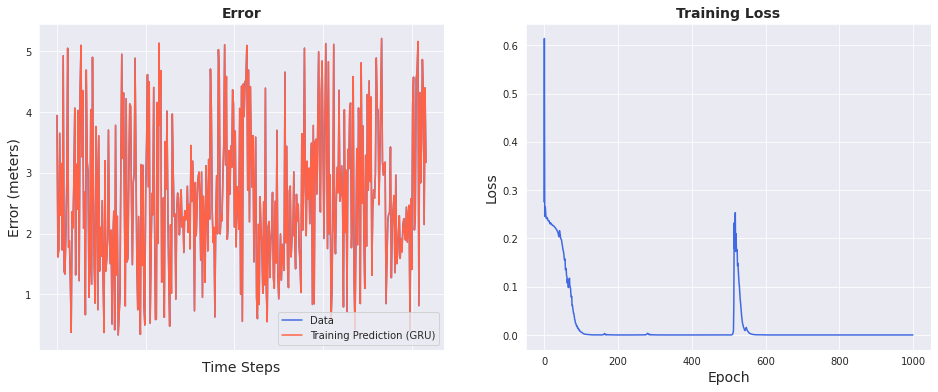

In [ ]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Error', size = 14, fontweight='bold')
ax.set_xlabel("Time Steps", size = 14)
ax.set_ylabel("Error (meters)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 1.08 RMSE
Test Score: 1.18 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(err)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(err)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(err)-1, :] = y_test_pred

original = scaler.inverse_transform(err['error'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

##### The GRU is slightly but noticably less accurate at predicting error in a given timestep. 
##### In the test data, the GRU was only accurate for a very small number of timesteps. 
##### This is expected, as GRU's are generally considered simpler and less computationally expensive versions of LSTM's. 

In [ ]:
# Comparing the two models side by side. 
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,0.068785,2.680660e-07
Test RMSE,1.565361,1.401695e+00
Train Time,295.752584,2.315343e+02


### Building the Modified Linear Kalman Filter
##### It was recommended that...

In [ ]:
unique = win.date.unique()
water_mean = []
for i in range(len(unique)): 
  mean = win[(win['date'] == unique[i])].water_level.mean()
  water_mean.append(mean)

In [ ]:
# Step 4, building the Model
#Initialization
_o = "old"
_n = "new"
x = "Water Level Estimations"
x_o = water_mean[0]
p = "Estimated Error" 
p_o = np.mean(errors)# --> Error variance

# Initial Prediction
x_n = x_o # (217.3659023809524) 
q = 0.125 # --> Process Uncertainty 
p_n = p_o + q 
x_o = x_n
p_o = p_n 

In [ ]:
kalman_gains = [] # --> To record the Kalman Gains per iteration.
water_est = [] # --> To record the predicted water levels. 
kf_errors = [] # --> To record the estimated errors. 
noise = [] # --> To record the unmeasurable variability, 'q', aka 'noise'

for i in range(len(water_mean)):
  # Measure
  z = water_mean[i]
  err = errors[i] * errors[i]
  # Update
  k = p_n /(p_o + err)
  kalman_gains.append(k)
  x_n = x_o + k * (z-x_o)
  water_est.append(x_n)
  p_n = (1-k)*(p_o)
  if i >= 1:
    if i%80==0:
      rnn = result[2][i] 
      p_n = (1-k)*(rnn)
  kf_errors.append(p_n)
  x_o = x_n
  # Prediction
  x_n = x_o
  p_n = p_o + q
  p_o = p_n
  #Create the Random Forest Regressor pass
  if i >= 1:
    
    if i%80==0:
      rnn = result[2][i] 
      p_n = (1-k)*(p_o) + q
      p_o = p_n
  noise.append(q)

  

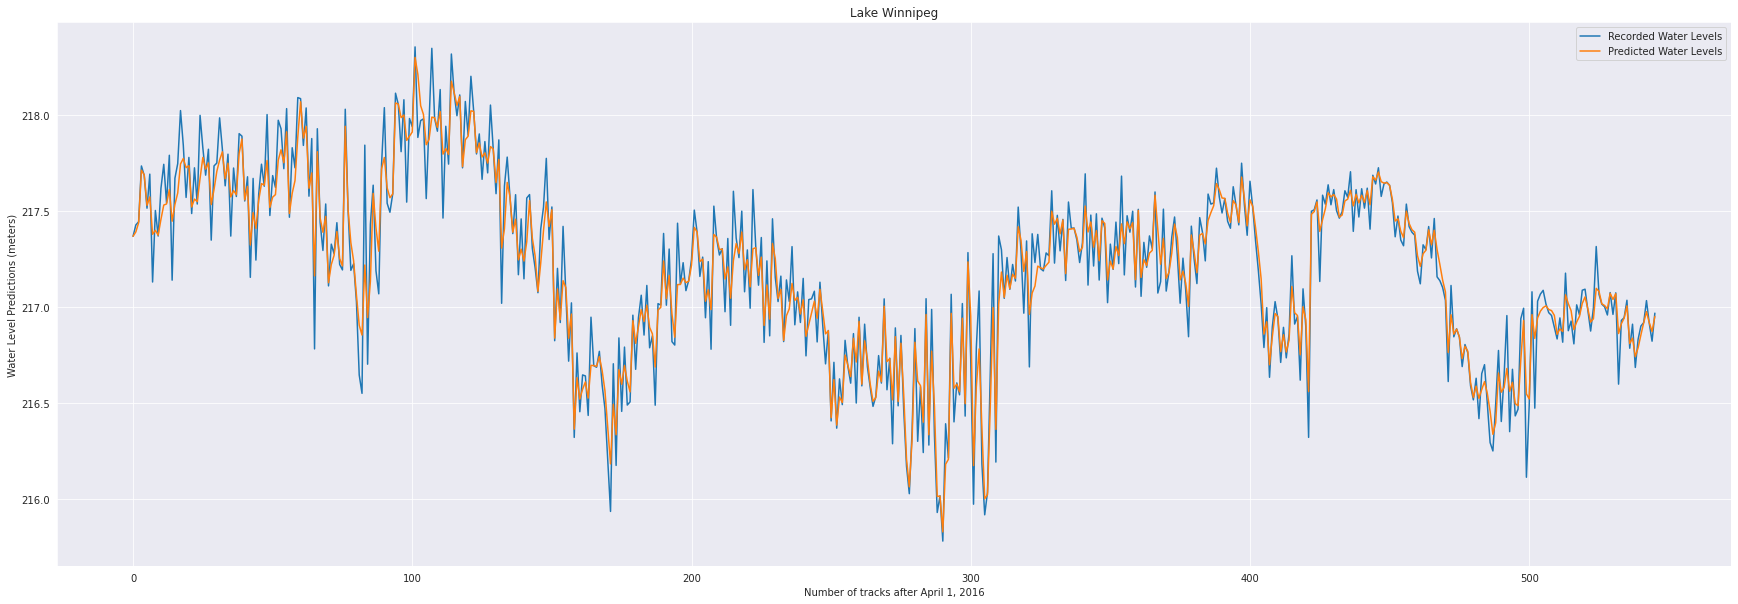

In [ ]:
# Now to plot the estimated water levels against the recorded measurements. 
x = range(len(water_mean))
y2 = water_est
y = water_mean

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Recorded Water Levels')
plt.plot(y2, label = 'Predicted Water Levels')

plt.legend()
plt.show()

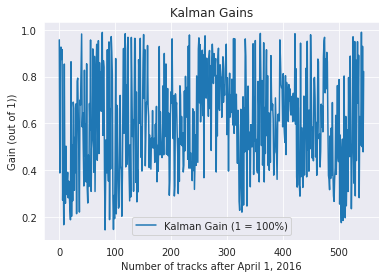

In [ ]:
# And finally to observe if the Kalman Gain was narrowing in on 0:
x = range(len(kalman_gains))
y = kalman_gains
plt.title("Kalman Gains")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Gain (out of 1))")
plt.plot(x,y, label = 'Kalman Gain (1 = 100%)')
plt.legend()
plt.show()

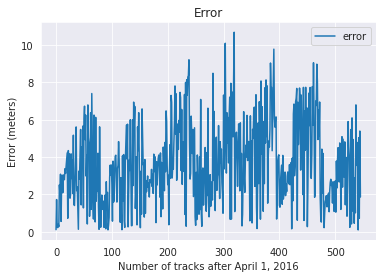

In [ ]:
# And finally to observe what the pattern of the errors is:
x = range(len(errors))
y = kf_errors
plt.title("Error")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y, label='error')
plt.legend()
plt.show()

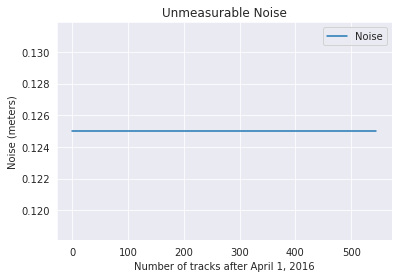

In [ ]:
# And finally to observe if the noise is increasing or decreasing. 
x = range(len(noise))
y = noise
plt.title("Unmeasurable Noise")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Noise (meters)")
plt.plot(x,y, label = 'Noise')
plt.legend()
plt.show()

In [ ]:
total = 0
for i in range(len(water_est)):
  if water_est[i] < water_mean[i]:
    answer = water_est[i]  - (water_mean[i] - ((1-kalman_gains[i])*errors[i]))
  elif water_est[i] >= water_mean[i]:
    answer = water_est[i] - (water_mean[i] + ((1-kalman_gains[i])*errors[i]))
  total += answer

In [ ]:
total

84.04941654145449

### Both the LSTM and GRU can be easily improved! 
##### The number of neurons per layer and number of layers was a minimal standard, and not relevant to the training data whatsover. Especially since the GRU took longer than the LSTM suggests that the models are optimized at all. 

#### This is what has been covered. 
##### Both models are follow similar patterns on training and test data. 
##### On the former, the model (as simple and unoptimixed as it is), is relatively good at predicting the error when the velocity and amplitudes follow a pattern. When the error changes its pattern, the model is thrown off. 
##### With the test data, the models were only accurate for the first 5-10 timesteps, then were generally innacurate after that. 
##### Thus, a simple first solution would be to create a neural network that observes the past 'x' steps and makes a prediction on the error for the next step; replacing this estimation aspect of the Kalman Filter. 

In [ ]:
# GRU
# GRU class remains unchanged, for now
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
# GRU instantiation, loss and optimization functions remain the same, for now. 
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# initial 21 steps


In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    if t%100 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.24772953987121582


KeyboardInterrupt: ignored

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

In [ ]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Error', size = 14, fontweight='bold')
ax.set_xlabel("Time Steps", size = 14)
ax.set_ylabel("Error (meters)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(err)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(err)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(err)-1, :] = y_test_pred

original = scaler.inverse_transform(err['error'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()